# Site Location Mapping

## Step one: set the weighting for each attribute


In [1]:
# Import libraries 
from ipywidgets import interactive
import ipywidgets as widgets
import csv
import numpy as np 
np.set_printoptions(threshold=np.inf)


# Define Map class 
class Map: 

    def __init__(self, attribute, number, maps):
        self.attribute = attribute
        self.id = number
        self.map_data = []
        self.maps  = maps
        self.widget = interactive(self.gui_weight, weighting = widgets.IntSlider(min=0,max=3,step=1,value=0,description=self.attribute))     
        self.weight = 0 
        
    def gui_weight(self, weighting): # function for interactive widget 
        return weighting
    
    def set_weight(self, event): # calculates weighted attributes from widget results
        total = self.maps[0].widget.result + self.maps[1].widget.result + self.maps[2].widget.result 
        for map in maps:
            map.weight += (map.widget.result / total)%100
            map.create_map_data()

    def create_map_data(self): # reads in raster data from text files
        raster_file = open(rasters[self.id], newline='') 
        reader = csv.reader(raster_file, quoting=csv.QUOTE_NONNUMERIC) 
        rowlist=[]

        for row in reversed(list(reader)):
            for value in row:
                rowlist.append(int(value) * self.weight)
            self.map_data.append(rowlist)
            rowlist = []
        raster_file.close()
        
        print('{} map created'.format(self.attribute))
        
    def combine(self): # for combining attribute maps to form final map
        rowlist = []
        data_rows = list(zip(self.maps[0].map_data, self.maps[1].map_data, self.maps[2].map_data)) # groups the corresponding rows together
        
        for row in data_rows: 
            pixel_values = list(zip(row[0], row[1], row[2]))
            for pixel in pixel_values:
                rowlist.append(float(pixel[0] + pixel[1] + pixel[2]))
            self.map_data.append(rowlist)
            rowlist=[]
        
# Define lists to hold map information 
attributes = ['geology', 'transport', 'population']
rasters = ['best.geology.txt', 'best.mway.txt', 'best.pop.txt']
maps = []

# Create maps 
for i in range(len(attributes)):
    maps.append(Map(attributes[i], i, maps))

    
# GUI interactive elements to set attribute weighting 

button = widgets.Button(
    value=False,
    description='Set weights',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Press to set or reset the attribute weights',
    icon='none'
)
    
for map in maps:
    display(map.widget)

display(button)
button.on_click(map.set_weight)

interactive(children=(IntSlider(value=0, description='geology', max=3), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=0, description='transport', max=3), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='population', max=3), Output()), _dom_classes=('widget-in…

Button(button_style='success', description='Set weights', icon='none', style=ButtonStyle(), tooltip='Press to …

geology map created
transport map created
population map created


## Step two: plot the map

<IPython.core.display.Javascript object>


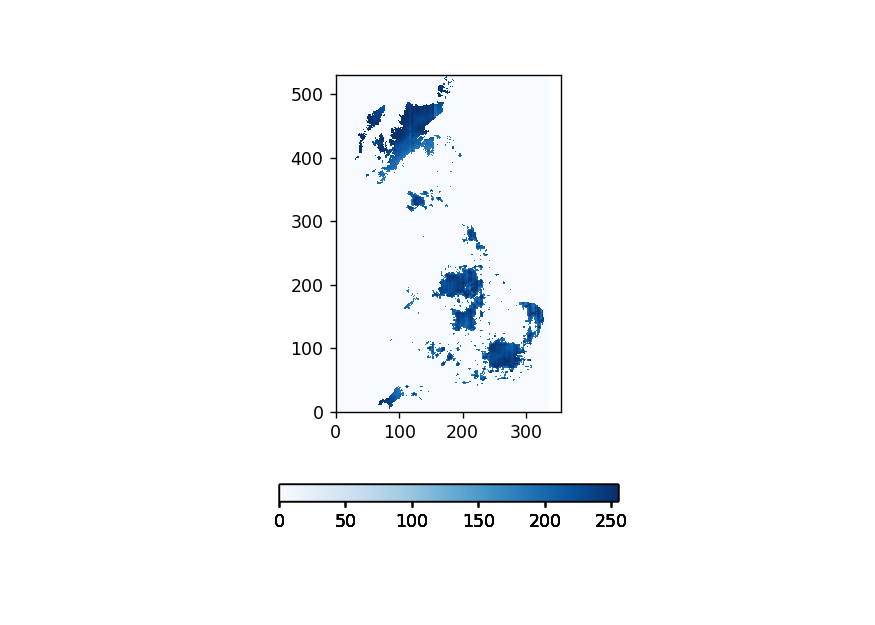

Button(button_style='info', description='View top 10% sites', icon='none', style=ButtonStyle(), tooltip='Press…

Button(button_style='info', description='View all sites', icon='none', style=ButtonStyle(), tooltip='Press to …

Button(button_style='success', description='Save map data to file', icon='none', style=ButtonStyle(), tooltip=…

In [3]:
# Import libraries 
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact
import sklearn.preprocessing 

# Define data and map functions 
class Visual:
    def __init__(self, map_data):
        self.map_data= map_data
        self.plotting_data= []
        self.button_a = widgets.Button(
            value=False,
            description='View top 10% sites',
            disabled=False,
            button_style='info',
            tooltip='Press to show only the top 10% of sites',
            icon='none'
        )
        self.button_b = widgets.Button (
            value=False,
            description='View all sites',
            disabled=False,
            button_style='info',
            tooltip='Press to revert map back to all sites',
            icon='none'
        )
        self.button_c = widgets.Button (
            value=False,
            description='Save map data to file',
            disabled=False,
            button_style='success',
            tooltip='Press to save map data to text file',
            icon='none'
        )
        
    def scale_data(self):
        # x = np.array(data)
        min_max_scaler = sklearn.preprocessing.MinMaxScaler(feature_range =(0, 255), copy=True)
        self.plotting_data = min_max_scaler.fit_transform(self.map_data)
    
    def plot_map(self):
        fig = plt.figure(num= 1, figsize=(7, 5))
        axes = plt.gca() 
        axes.set_xlim([0,355]) 
        axes.set_ylim([0,530])
        plt.imshow(self.plotting_data, cmap='gray')
        plt.colorbar(ax = axes, orientation= 'horizontal', shrink = 0.5)
        display(self.button_a)
        display(self.button_b)
        self.button_b.layout.visibility = 'hidden'
        display(self.button_c)
        self.button_a.on_click(self.show_top_ten)
        self.button_b.on_click(self.show_all)
        self.button_b.on_click(self.save_map)
    
    def show_all(self, event):
        cb=plt.colorbar()
        axes = plt.gca() 
        cb.remove()
        plt.imshow(self.plotting_data, cmap='gray')
        plt.colorbar(ax = axes, orientation= 'horizontal', shrink = 0.5)
        self.button_a.layout.visibility = 'visible'
        self.button_b.layout.visibility = 'hidden'

    def show_top_ten(self, event):
        cb=plt.colorbar()
        axes = plt.gca() 
        top_10 = []
        percentile_90 = int(np.percentile(self.plotting_data, 90))
        cb.remove() 

        for row in self.plotting_data:
            rowlist=[]
            for value in row:
                if value >= percentile_90:
                    rowlist.append(value)
                else:
                    rowlist.append(0)
            top_10.append(rowlist)
            
        plt.imshow(top_10, cmap='Blues')
        plt.colorbar(ax = axes, orientation= 'horizontal', shrink = 0.5)
        
        self.button_a.layout.visibility = 'hidden'
        self.button_b.layout.visibility = 'visible'
                   
    def save_map(self, event):
        with open('final_map.txt', 'w') as f:
            f.write("FINAL MAP DATA: \n")
            for row in final_map.map_data: 
                f.write(" ".join(str(value) for value in row) +"\n")
            f.close()
    


        


# Create final combined Map object and scale its data 
final_map = Map('final', 3, maps)
final_map.combine()
map_display = Visual(final_map.map_data)
map_display.scale_data()

# Map display 

map_display.plot_map()


